# KNN

## KD-TREE 类构造

In [323]:
import numpy as np
from typing import *
from graphviz import Digraph
import heapq
from scipy.spatial import cKDTree
from collections import Counter


class NODE:
    """ 树节点 """
    def __init__(self, point: List, idx:int, level: int, parent: 'NODE' = None, left: 'NODE' = None, right: 'NODE'=None):
        self.point = point # 数据点
        self.idx = idx # 数据点在原始数据中的索引
        self.level = level # 节点所在的层级（划分维度）
        self.parent = parent # 父节点
        self.left = left # 左子节点
        self.right = right # 右子节点

class KD_TREE:
    """ NODE 组成的 kd_tree """
    def __init__(self, X: List, Label: List):
        # 附加索引到数据点
        indexed_X = [(point, i) for i, point in enumerate(X)]
        self.root = self.__get_kd_tree(indexed_X, 0)
        self.points = X # 数据
        self.label = Label # 标签
    
    ### 初始化构建 KD_tree
    def __get_kd_tree(self, indexed_X: List[tuple], level: int, parent: NODE = None) -> NODE:
        """ 构建kd tree
        X : m 维特征向量 
        level : 以第 level 维进行超平面划分
        """
        n = len(indexed_X) # 向量数
        if n==0:
            return None
        
        dim = len(indexed_X[0][0]) # 特征维数
        level = level%dim # 第level维进行划分
        indexed_X.sort(key=lambda x: x[0][level]) # 按照第level维进行排序
        mid = n//2
        root = NODE(indexed_X[mid][0],indexed_X[mid][1], level, parent) # 中值
        root.left = self.__get_kd_tree(indexed_X[:mid], level+1, root)
        root.right = self.__get_kd_tree(indexed_X[mid+1:], level+1, root)
        return root

    ### 层序遍历
    def level_travel(self) -> List:
        """ 层序遍历 """
        nn = self.root
        if nn is None:
            return None
        ans = []
        res = [nn]
        while len(res):
            tmp = []
            for node in res:
                tmp.append(node)
            ans.append([i.point for i in tmp])
            res.clear()
            for node in tmp:
                if node.left:
                    res.append(node.left)
                if node.right:
                    res.append(node.right)
        return ans

    ### 绘图
    def __add_node(self, dot, node, parent_id=None, i=0, edge_label=''):
        """ 添加节点 """
        loc = node.point
        node_id = str(i)
        dot.node(node_id, f"[{node.idx}]\n({','.join(str(i) for i in loc)})")
        if parent_id:
            dot.edge(parent_id, node_id, label=edge_label)
        if node.left:
            i = self.__add_node(dot, node.left, node_id, i + 1, f'left dim:{node.level}')
        if node.right:
            i = self.__add_node(dot, node.right, node_id, i + 1, f'right dim:{node.level}')
        return i

    def create_graph(self):
        """ 绘图 """
        dot = Digraph(comment='Kd-tree')
        dot.attr('node',
                fontsize='10',
                shape='circle',
                width='1',
                fixedsize='true')
        dot.attr('edge', arrowsize='0.7')
        self.__add_node(dot, self.root)
        return dot

    ### 获取最近的 k 个节点
    def __point_dist(self, A:List, B:List, p: float=2) ->float:
        """ 计算距离 """
        X=np.array(A)
        Y=np.array(B)
        return np.sum(np.abs(X - Y)**p)**(1 / p)

    def __bin_insert(self, dists_indexs:List, dist_index: List, k: int=1)->List:
        """ 二分插入 
        - dists_indexs: [[dis, index], [] ...]
        - dist_index: [dis, index] 
        """
        r = len(dists_indexs)
        if r==0:
            dists_indexs.append(dist_index)
            return dists_indexs
        if dist_index[0]>=dists_indexs[-1][0]:
            return dists_indexs
        l=0
        r=r-1
        while(l < r):
            mid = (l+r)//2
            if dist_index[0] > dists_indexs[mid][0]:
                l = mid + 1
            elif dist_index[0] < dists_indexs[mid][0]:
                r = mid - 1
        dists_indexs.insert(max(l,r),dist_index)
        if(len(dists_indexs)>k):
            dists_indexs.pop()
        return dists_indexs

    # BBF 优化 k-d 树搜索的算法
    def search_k_nearest_neighbors(self, target: List, k: int=1) -> List[tuple]:
        """搜索最近的 k 个节点
        - target: 目标点（待搜索的点）
        - k: 要找到的最近邻节点数
        """
        def search_nearest(node, target, k, heap):
            if node is None:
                return

            dist = self.__point_dist(node.point, target)
            dist_index = [dist, node.idx]

            heap = self.__bin_insert(heap, dist_index, k)

            split_dim = node.level
            if target[split_dim] < node.point[split_dim]:
                search_nearest(node.left, target, k, heap)
                if len(heap) < k or abs(target[split_dim] - node.point[split_dim]) < heap[0][0]:
                    search_nearest(node.right, target, k, heap)
            else:
                search_nearest(node.right, target, k, heap)
                if len(heap) < k or abs(target[split_dim] - node.point[split_dim]) < heap[0][0]:
                    search_nearest(node.left, target, k, heap)

        heap = []
        search_nearest(self.root, target, k, heap)

        return  [heap_item[0] for heap_item in heap], [heap_item[1] for heap_item in heap]

    def get_knn(self, target: List, k: int =1) -> List:
        """ 获取k个nn
        - target: [x0,x1,..] 一个目标点
        - k: 1  
        
        return  
        - dis: []
        - index: []

        使用实示例：
        - dis, idx = kd_tree.get_knn([5.1,7], 2)
        - for d, i in zip(dis, idx):
        - \tprint(d,i)
        """
        kd_tree = cKDTree(self.points)
        return kd_tree.query(target, k)
    
    # 获取预测标签
    def get_predict_accu_label(self, X_test: List, k: int=3)->int:
        """ X_test: [[1,1],[1,3],[]...] """
        accu = []
        label = []
        for x in X_test:
            _, indexs = self.get_knn(x, k)
            if k!=1:
                labs = [self.label[i] for i in indexs]    
                lab, times = Counter(labs).most_common(1)[0]
                label.append(lab)
                accu.append(times/len(indexs))
            else:
                label.append(self.label[indexs])
                accu.append(1.00)
        return accu, label
        

使用

[7, 2]
5


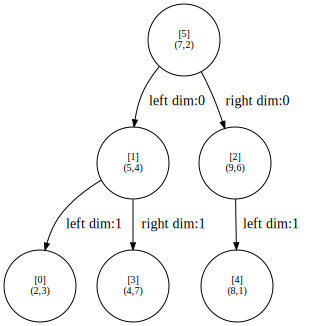

In [324]:
points = [[2, 3], [5, 4], [9, 6], [4, 7], [8, 1], [7, 2]]
label = [0,1,1,1,1,1]

kd_tree = KD_TREE(points,label)
print(kd_tree.root.left.parent.point)
print(kd_tree.root.idx)
kd_tree.create_graph()

In [325]:
nearest_neighbors = kd_tree.search_k_nearest_neighbors([2,4.5], 4)
print(nearest_neighbors)
ans = kd_tree.get_knn([2,4.5], 4)
print(ans)


([1.5, 3.0413812651491097, 3.2015621187164243, 5.5901699437494745], [0, 1, 3, 5])
(array([1.5       , 3.04138127, 3.20156212, 5.59016994]), array([0, 1, 3, 5]))


In [326]:
kd_tree.get_predict_accu_label([[8,2], [1,1], [3,3]], 3)

([1.0, 0.6666666666666666, 0.6666666666666666], [1, 1, 1])

In [273]:
from time import process_time
from random import random


# 产生一个k维随机向量，每维分量值在0~1之间
def random_point(k):
    return [random() for _ in range(k)]


# 产生n个k维随机向量
def random_points(k, n):
    return [random_point(k) for _ in range(n)]

In [281]:
import random

def random_points(dimensions, N):
    """生成N个随机点，每个点有指定维度，并且坐标值在[0, 100]之间
    :param dimensions: 点的维度
    :param N: 需要生成的随机点数量
    :return: 一个包含随机点的列表
    """
    points = []
    for _ in range(N):
        point = [random.randint(0, 100) for _ in range(dimensions)]
        points.append(point)
    return points

# 生成包含10个三维随机点的列表
N = 2000
points = random_points(3, N)

t0 = process_time()
kd = KD_TREE(points)  # 构建包含四十万个3维空间样本点的kd树
nearest_neighbors = kd.search_k_nearest_neighbors([0.1, 0.5, 0.8], 3) # 四十万个样本点中寻找离目标最近的点
t1 = process_time()
print("time: ", t1 - t0, "s")
print(nearest_neighbors)

t0 = process_time()
nearest_neighbors = kd.get_knn([0.1, 0.5, 0.8], 3) # 四十万个样本点中寻找离目标最近的点
t1 = process_time()
print("time: ", t1 - t0, "s")
print(nearest_neighbors)


time:  0.011052728999999317 s
([10.232301793829187, 7.273238618387273, 14.089002803605371], [1461, 1361, 1518])
time:  0.0023846560000038153 s
(array([ 7.27323862, 10.23230179, 10.9772492 ]), array([1361, 1461, 1433]))


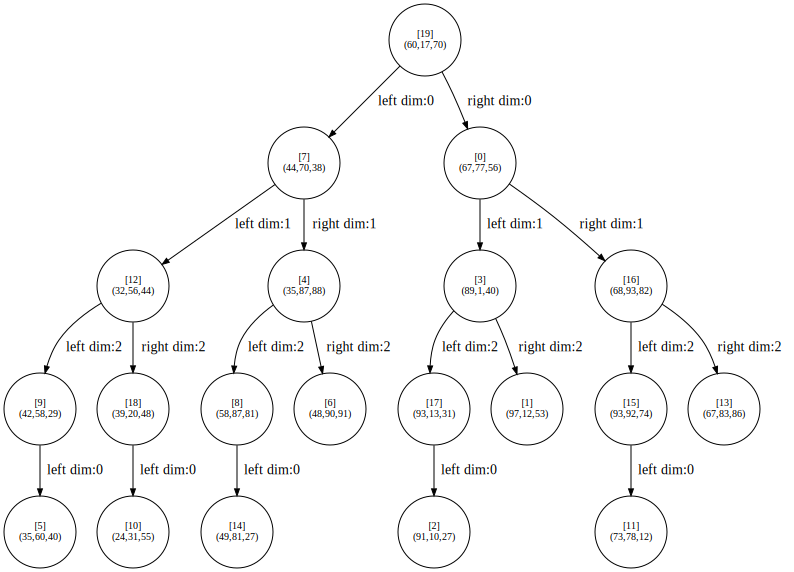

In [262]:
kd.create_graph()

## 交叉验证


In [334]:
import random
import statistics

class KNN_CROSS_VALIDATION:
    def __init__(self, kd_tree: KD_TREE, k: int=5):
        self.kd_tree = kd_tree # kd_tree
        self.k=k # k-fold
        self.folds=[]
        self.mean_accu, self.stdev = self.__get_knn_accuracy(k)

    def __get_knn_accuracy(self, k: int=5):
        """ k: fold_nums """
        n = len(self.kd_tree.points)
        points = self.kd_tree.points.copy()
        random.shuffle(points) # 随机打乱
        step = n//k
        splitted_points = [points[i: i+step] for i in range(0, n, step)] # 互斥划分
        del points
        accus = []

        # 每折的均值
        for sp_point in splitted_points:
            accu, _ = self.kd_tree.get_predict_accu_label(sp_point, k)
            mean = statistics.mean(accu)
            self.folds.append(mean)

        mean = statistics.mean(self.folds)
        stdev = statistics.stdev(self.folds)
        return mean, stdev



In [336]:
kcv = KNN_CROSS_VALIDATION(kd_tree, 5)
print(kcv.mean_accu)
print(kcv.stdev)
for i in kcv.folds:
    print(i)

0.8333333333333334
0.08164965809277258
0.8
0.8
0.8
1.0
0.8
0.8


In [331]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# 训练数据
points = np.array([[2, 3], [5, 4], [9, 6], [4, 7], [8, 1], [7, 2]])
label = np.array([0, 1, 1, 1, 1, 1])

# 测试数据
test_data = np.array([[8, 2], [1, 1], [3, 3]])

# 创建KNN模型
knn = KNeighborsClassifier(n_neighbors=3)

# 使用交叉验证来评估模型性能
scores = cross_val_score(knn, points, label, cv=5, scoring='accuracy')

# 打印每折的验证准确率
for fold, score in enumerate(scores, 1):
    print(f"Fold {fold}: {score}")

# 训练模型并预测测试数据
knn.fit(points, label)
predictions = knn.predict(test_data)

print("测试数据的预测结果:")
for i, prediction in enumerate(predictions):
    print(f"Test data {i+1}: Predicted label {prediction}")


Fold 1: 0.5
Fold 2: 1.0
Fold 3: 1.0
Fold 4: 1.0
Fold 5: 1.0
测试数据的预测结果:
Test data 1: Predicted label 1
Test data 2: Predicted label 1
Test data 3: Predicted label 1


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [283]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import load_iris

# 加载示例数据集（这里使用鸢尾花数据集）
data = load_iris()
X = data.data
y = data.target


In [284]:
# 创建随机森林分类器
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 创建一个 KFold 对象，将数据集分成 5 份
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 使用 cross_val_score 函数进行交叉验证
scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# 输出结果
print("交叉验证准确率: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


交叉验证准确率: 0.96 (+/- 0.05)


In [286]:
import numpy as np

# 假设 data 是一个包含所有数据点的数组
data = np.array([1,1,1,1,1])
# 计算均值
mean = np.mean(data)

# 计算每个数据点与均值的差的平方
squared_diff = (data - mean) ** 2

# 计算方差
variance = np.mean(squared_diff)

# 计算标准差
std_deviation = np.sqrt(variance)


## 读取数据

In [190]:
import numpy as np
from scipy.spatial import cKDTree

# 假设我们有以下规则的二维 NumPy 数组
# 每一行代表空间中的一个点，这里假设是二维空间
points = np.array([[2, 3], [5, 4], [9, 6], [4, 7], [8, 1], [7, 2]])

# 使用 points 构造 KD 树
tree = cKDTree(points)

# 现在你可以使用 KD 树进行查询，例如查找最近的点
ans = tree.query([5.1,7], 2)
# for i in ans:
ans


(array([1.1      , 3.0016662]), array([3, 1]))